In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Lambda, Layer, Add
from tensorflow.keras import backend as K
import plotly.express as px
import cv2

In [2]:
class Sampling(Layer):
    """Génère des simulations de loi normale (z_men, z_sigma)"""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    
class Encoder(Layer):
    '''
    Definit la couche encoder du VAE. Génère les outputs: 
    - la moyenne z_mu (moyenne)
    - le log de la variance z_log_var 
    - Des simulations d'une loi normale de paramètres z_mu, z_sigma (transforamtion de z_log_bar)
    '''
    
    def __init__(self, latent_dim, intermediate_dim = [256], name = 'encoder', **kwargs):
        '''
        Inputs:
        - latent_dim : int. Dimension de l'espace latent
        - intermediate_dim : list. Nombre de neurones des couches de l'encoder
        - name : string. Nom du réseau
        '''
        super(Encoder, self).__init__(name = name, **kwargs)
        
        #couches intermédiaires
        self.seq = Sequential()
        for i in intermediate_dim:
            self.seq.add( Dense(i, activation = 'relu') )

        #output
        self.mean = Dense(latent_dim)
        self.log_var = Dense(latent_dim)
        
        #sampling
        self.sampling = Sampling()
        
    def call(self, inputs):
        x = self.seq(inputs)
        z_mu = self.mean(x)
        z_log_var = self.log_var(x)
        z = self.sampling((z_mu, z_log_var))
        
        return z_mu, z_log_var, z
        

class Decoder(Layer):
    '''
    Encode les variable z de l'espace latent pour reconstruire l'image
    '''
    
    def __init__(self, original_dim, intermediate_dim = [256], name = 'decoder', **kwargs):
        '''
        Inputs : 
        - original_dim : int. Dimension d'origine des données
        - intermediate_dim : list. Dimension de chaque couche intermédiaire
        - name : string. Nom du bloc
        '''
        
        super(Decoder, self).__init__(name = name, **kwargs)
        
        #couches intermédiaires
        self.seq = Sequential()
        for i in intermediate_dim:
            self.seq.add( Dense(i, activation = 'relu') )
        
        #couche finale
        self.final = Dense(original_dim, activation = 'sigmoid')
        
    def call(self, inputs):
        
        x = self.seq(inputs)
        return self.final(x)

In [3]:
class Network(Model):
    '''Combine l'encoder et le decoder pour créer un Model Tensorflow'''

    def __init__(self, original_dim, intermediate_dim_encoder=[64], intermediate_dim_decoder = [64],
                 latent_dim=32, name="autoencoder", **kwargs):
        '''
        Inputs:
        - original_dim : int. Dimension des données
        - intermdiate_dim_encoder / intermediate_dim_decoder : list. Dimension des couches intermédiaires de 
        l'encoder/decoder
        - latent_dim = int. Dimension de l'espace latent
        -name : string. Nom du réseau
        '''
        super(Network, self).__init__(name=name, **kwargs)
        
        #encoder
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim_encoder)
        
        #decoder
        self.decoder = Decoder(original_dim = original_dim, intermediate_dim=intermediate_dim_decoder)

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean( z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed


In [4]:
class VAE():
    '''
    Crée un VAE Tensorflow Model. Une fois entrainé, il permet de:
    - de générer des données
    - de visualiser l'esapce latent
    - d'évaluer la qualité du modèle
    '''
    
    def model(self, original_dim, intermediate_dim_encoder=[64], intermediate_dim_decoder = [64], 
              latent_dim=32, name="autoencoder", **kwargs):
        '''
        Crée le réseau VAE
        
        Inputs :
        - original_dim : int. Dimension originale des données
        - intermediate_dim_encoder/decoder : list. Dimension des couches intermédiaires
        - latent_dim : int. Dimension de l'espace latent
        - name : str. Nom de réseau
        
        Output:
        - VAE Tensorflow Model
        '''
        self.original_dim = original_dim
        self.latent_dim = latent_dim 
        self.network = Network(original_dim, intermediate_dim_encoder = intermediate_dim_encoder, 
                              intermediate_dim_decoder = intermediate_dim_decoder ,latent_dim = latent_dim, 
                              name = name, **kwargs)
        
        return self.network  
    
    
    def generate(self, sample = 100):
        '''
        Génère des données aléatoirement. Fit le model avant!!
        '''
        # récupérer le decoder
        decoder = self.network.decoder
        
        #sample variables latentes
        sample = K.random_normal(shape=(sample, self.latent_dim))
        
        #générer des observations
        data = decoder(sample)
        
        return data
    
    def latent_feature(self, data, label = None, plot2D = True, x_axis = 'z_1', y_axis = 'z_2', z_axis = 'z_3'):
        '''
        Plot l'espace latent en 2 (si plot2D = True) ou 3 (si plot2D = False) dimensions
        Fit le model avant!! 
        Mettre data aux dimensions correspondants au réseau
        
        Inputs : 
        - data : array, liste, tensor...
        - label : array, liste, tensor... pour distinguer les points sur le plot
        - plot2D : Booléen
        - x/y/z_axis : string. Noms des axes sur le plot
        '''
        #récupérer l'encoder
        encoder = self.network.encoder
        
        #predict
        _, _, z_test = encoder(data)
        
        #plot
        if plot2D :
            fig = px.scatter(x = z_test[:,0], y = z_test[:,1], color = label, labels={'x':x_axis, 'y':y_axis})
            fig.show()
            
        else : 
            fig = px.scatter_3d(x = z_test[:,0], y = z_test[:,1], z = z_test[:,2], color = label, 
                          labels={'x':x_axis, 'y':y_axis, 'z': z_axis})
            fig.show()
        
    def see_reconstruction(self, images, size):
        '''
        Plot côte à côte pour évaluer la qualité du réseau
        Fit le modèle avant!! 
        
        Inputs:
        - Images : Array (nb_image, hauteur, largeur) (attention: pas un tensor)
        - size : tuple. Nombre de figures par ligne et colonne
        
        Output:
        - figure plotly 
        '''
        
        assert images.shape[0] <= size[0]*size[1]
        
        _ , h, w = images.shape
        
        assert h*w == self.original_dim
        
        #tableau pour afficher images
        img = np.zeros((h*size[0], w*size[1]))
        
        #tableau pour afficher la reconstruction
        img_pred = np.zeros((h*size[0], w*size[1]))
        
        print('Reconstruction des images...')
        pred = self.network.predict(images.reshape(-1, h*w)).reshape(-1, h, w)
        
        print('Affichage...')
        for idx, (image, image_pred) in enumerate(zip(images, pred)):
    
            i = int(idx % size[1])
            j = int(idx / size[1])
    
            image_ = cv2.resize(image, dsize = (h, w), interpolation=cv2.INTER_CUBIC)
            image_pred_ = cv2.resize(image_pred, dsize = (h, w), interpolation=cv2.INTER_CUBIC)
    
            img[j*h:j*h+h, i*w:i*w+w] = image_
            img_pred[j*h:j*h+h, i*w:i*w+w] = image_pred
        
        
        #plot
        fig = px.imshow(np.array([img, img_pred]), facet_col = 0, facet_col_wrap=2, 
                        binary_string = True, title="True data vs Reconstruction data")
        fig.for_each_annotation(lambda a: a.update(text=''))
        fig.update_yaxes(showticklabels=False, )
        fig.update_xaxes(showticklabels=False)
        fig.show()
        
        
    

In [5]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy retourne la moyene
    # sur le dernier axe. On doit sommer
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(-1, 784).astype("float32") / 255



# Espace latent dimension 2

In [7]:
#instancie le modèle
vae = VAE()

#crée notre réseau
vae_network = vae.model(784, intermediate_dim_encoder = [512, 128, 64], 
                        intermediate_dim_decoder = [512, 128, 64], latent_dim = 2)


In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

vae_network.compile(optimizer, loss=nll)
vae_network.fit(x_train, x_train, epochs=30, batch_size=128, validation_data = (x_test, x_test))

Epoch 1/30
469/469 [==============================] - 8s 14ms/step - loss: 248.5496 - val_loss: 173.5611
Epoch 2/30
469/469 [==============================] - 6s 12ms/step - loss: 171.8899 - val_loss: 162.7275
Epoch 3/30
469/469 [==============================] - 6s 12ms/step - loss: 160.6853 - val_loss: 154.5282
Epoch 4/30
469/469 [==============================] - 8s 16ms/step - loss: 154.1793 - val_loss: 153.5025
Epoch 5/30
469/469 [==============================] - 9s 20ms/step - loss: 151.5143 - val_loss: 150.1488
Epoch 6/30
469/469 [==============================] - 8s 17ms/step - loss: 149.4895 - val_loss: 147.9103
Epoch 7/30
469/469 [==============================] - 8s 16ms/step - loss: 148.3150 - val_loss: 146.3916
Epoch 8/30
469/469 [==============================] - 8s 16ms/step - loss: 146.7997 - val_loss: 145.2407
Epoch 9/30
469/469 [==============================] - 7s 15ms/step - loss: 145.7740 - val_loss: 144.5586
Epoch 10/30
469/469 [==============================] - 

In [25]:
fig = px.line(x = np.arange(1,31), y = [vae_network.history.history["loss"], vae_network.history.history["val_loss"]], 
              labels={'x':'epochs', 'y':'value'})
fig['data'][0].name = 'loss'
fig['data'][1].name = 'eval_loss'
fig.show()

## Espace Latent

In [26]:
vae.latent_feature(x_test, label = y_test, plot2D = True)

Reconstruction des images...
Affichage...



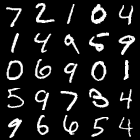
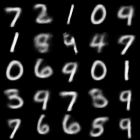

In [27]:
vae.see_reconstruction(x_test[0:25].reshape(-1,28,28), (5,5))

## Génération de données

In [28]:
data = tf.reshape(vae.generate(sample = 25), (-1,28,28))

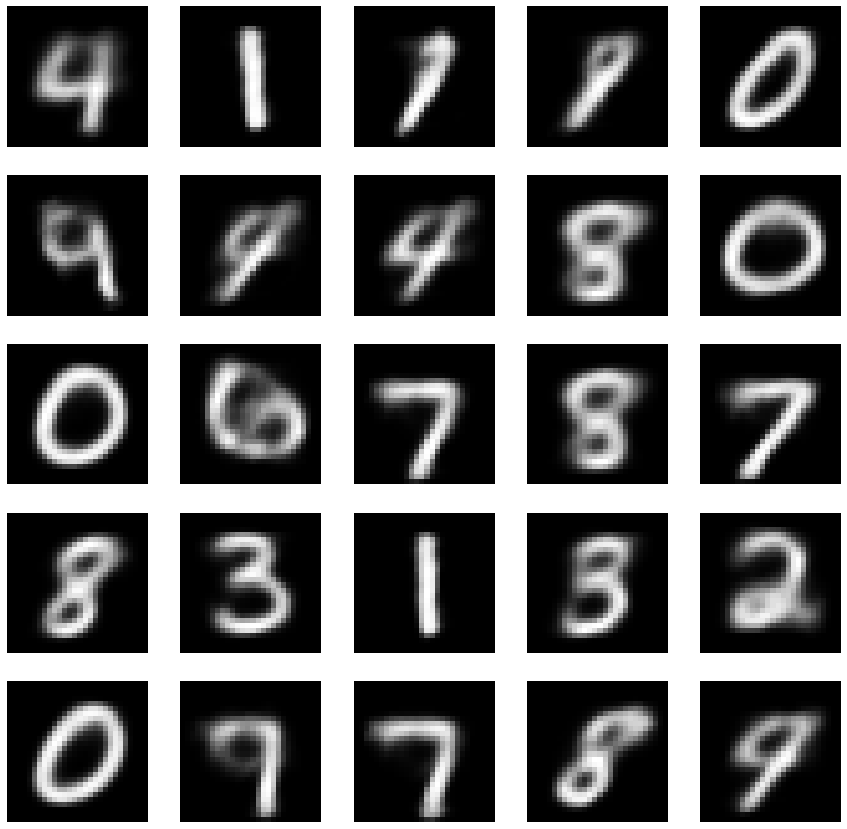

In [30]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(15,15))
idx = 1
for i in range(5):
    for j in range(5):
        plt.subplot(5,5, idx)
        
        plt.imshow(data[idx-1], cmap = 'gray')
        plt.axis('off')
        idx +=1

# Espace latent dimension 3

In [31]:
#instancie le modèle
vae_3 = VAE()

#crée notre réseau
vae_network = vae_3.model(784, intermediate_dim_encoder = [512, 128, 64], 
                        intermediate_dim_decoder = [512, 128, 64], latent_dim = 3)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

vae_network.compile(optimizer, loss=nll)
vae_network.fit(x_train, x_train, epochs=30, batch_size=128, validation_data = (x_test, x_test))

Epoch 1/30
469/469 [==============================] - 7s 13ms/step - loss: 242.5379 - val_loss: 164.5866
Epoch 2/30
469/469 [==============================] - 6s 12ms/step - loss: 160.8207 - val_loss: 150.7236
Epoch 3/30
469/469 [==============================] - 6s 12ms/step - loss: 148.7129 - val_loss: 143.3049
Epoch 4/30
469/469 [==============================] - 6s 13ms/step - loss: 142.8145 - val_loss: 139.2816
Epoch 5/30
469/469 [==============================] - 6s 14ms/step - loss: 139.1406 - val_loss: 136.4277
Epoch 6/30
469/469 [==============================] - 6s 13ms/step - loss: 136.3353 - val_loss: 134.9338
Epoch 7/30
469/469 [==============================] - 8s 18ms/step - loss: 134.0304 - val_loss: 133.1138
Epoch 8/30
469/469 [==============================] - 9s 18ms/step - loss: 132.6453 - val_loss: 132.4504
Epoch 9/30
469/469 [==============================] - 7s 16ms/step - loss: 131.6954 - val_loss: 130.9926
Epoch 10/30
469/469 [==============================] - 

In [32]:
fig = px.line(x = np.arange(1,31), y = [vae_network.history.history["loss"], vae_network.history.history["val_loss"]], 
              labels={'x':'epochs', 'y':'value'})
fig['data'][0].name = 'loss'
fig['data'][1].name = 'eval_loss'
fig.show()

## Espace latent

In [33]:
vae_3.latent_feature(x_test, label = y_test, plot2D = False)

Reconstruction des images...
Affichage...



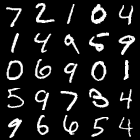
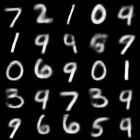

In [34]:
vae_3.see_reconstruction(x_test[0:25].reshape(-1,28,28), (5,5))

## Génération de données

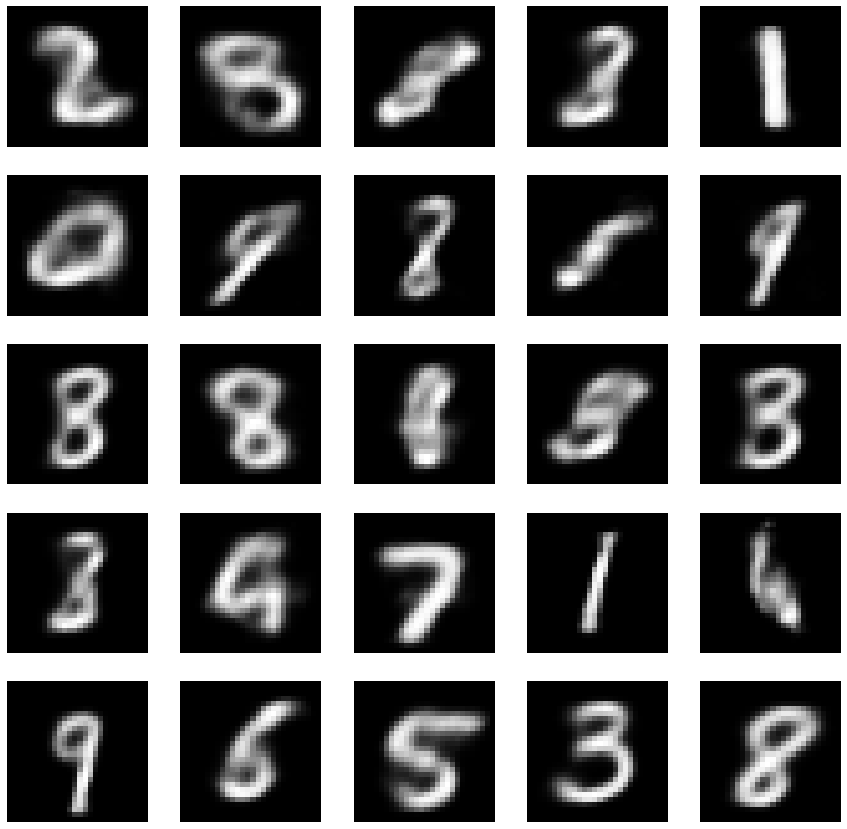

In [36]:
data_3 = tf.reshape(vae_3.generate(sample = 25), (-1,28,28))

plt.figure(figsize=(15,15))
idx = 1
for i in range(5):
    for j in range(5):
        plt.subplot(5,5, idx)
        
        plt.imshow(data_3[idx-1], cmap = 'gray')
        plt.axis('off')
        idx +=1
        